In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import sys

In [ ]:
def display_images(images):
    fig = plt.figure(figsize=(10, 7))

    for i, image in enumerate(images):
        ax = fig.add_subplot(1, len(images), i+1)
        ax.imshow(image)
        ax.axis('off')

    plt.show()

def encode_image(image, block_size, quant_matrix, loss_factor):
    height, width, channels = image.shape
    blocks = extract_blocks(image, block_size)

    compressed_blocks = []
    for block in blocks:
        dct_block = apply_dct(block, channels)
        quantized_block = quantize_dct(dct_block, quant_matrix, loss_factor)
        compressed_blocks.append(quantized_block)

    return compressed_blocks

def decode_image(compressed_blocks, block_size, quant_matrix, image_shape, loss_factor):
    reconstructed_blocks = []
    for block in compressed_blocks:
        dequantized_block = dequantize_dct(block, quant_matrix, loss_factor)
        idct_block = apply_idct(dequantized_block)
        reconstructed_blocks.append(idct_block)

    reconstructed_image = merge_blocks(reconstructed_blocks, block_size, image_shape)

    return reconstructed_image

def extract_blocks(image, block_size):
    height, width, channels = image.shape
    blocks = []

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = image[i:i+block_size, j:j+block_size, :]
            blocks.append(block)

    return blocks

def apply_dct(block, channels):
    block = block.astype(np.float32)
    dct_block = np.zeros_like(block)

    for c in range(channels):
        dct_block[:, :, c] = cv2.dct(block[:, :, c])

    return dct_block

def quantize_dct(dct_block, quant_matrix, loss_factor):
    scaled_quant_matrix = quant_matrix * loss_factor
    quantized_block = np.round(dct_block / scaled_quant_matrix[..., np.newaxis])

    return quantized_block

def dequantize_dct(quantized_block, quant_matrix, loss_factor):
    scaled_quant_matrix = quant_matrix * loss_factor
    dequantized_block = quantized_block * scaled_quant_matrix[..., np.newaxis]

    return dequantized_block

def apply_idct(block):
    idct_block = np.zeros_like(block)

    for c in range(block.shape[2]):
        idct_block[:, :, c] = cv2.idct(block[:, :, c])

    return idct_block

def merge_blocks(blocks, block_size, image_shape):
    height, width, channels = image_shape
    reconstructed_image = np.zeros((height, width, channels), dtype=np.uint8)
    block_idx = 0

    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = blocks[block_idx]
            reconstructed_image[i:i+block_size, j:j+block_size, :] = block
            block_idx += 1

    return reconstructed_image

def get_image_size(image):
    return sys.getsizeof(image) / (1024 * 1024)

def pad_image(image):
    new_width = (image.shape[1] + 7) // 8 * 8
    new_height = (image.shape[0] + 7) // 8 * 8

    padded_image = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    padded_image[:image.shape[0], :image.shape[1]] = image

    return padded_image

Original Images:


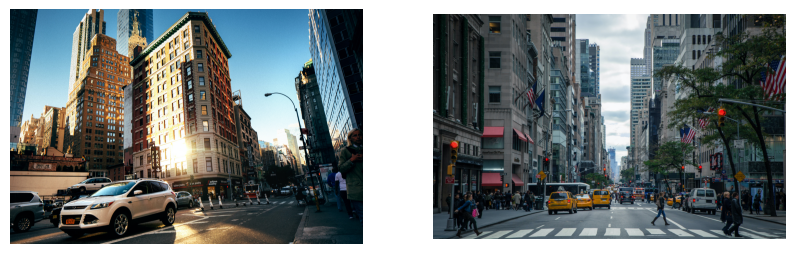

In [ ]:
original_img1 = cv2.imread("img1.jpg")
original_img1 = cv2.cvtColor(original_img1, cv2.COLOR_BGR2RGB)
original_img2 = cv2.imread("img2.jpg")
original_img2 = cv2.cvtColor(original_img2, cv2.COLOR_BGR2RGB)

print("Original Images:")
display_images([original_img1, original_img2])

Decompressed Images:


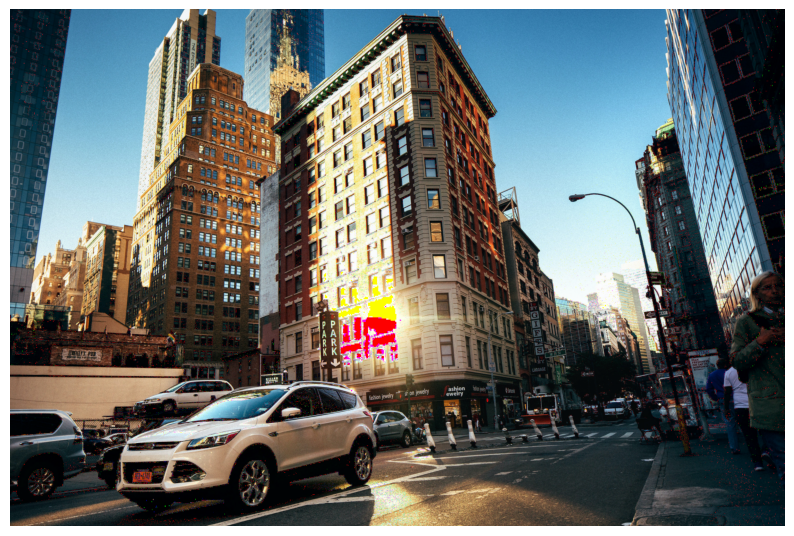

In [ ]:
block_size = 8
quant_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                         [12, 12, 14, 19, 26, 58, 60, 55],
                         [14, 13, 16, 24, 40, 57, 69, 56],
                         [14, 17, 22, 29, 51, 87, 80, 62],
                         [18, 22, 37, 56, 68, 109, 103, 77],
                         [24, 35, 55, 64, 81, 104, 113, 92],
                         [49, 64, 78, 87, 103, 121, 120, 101],
                         [72, 92, 95, 98, 112, 100, 103, 99]])

loss_factor = 1.0

compressed_img1 = encode_image(original_img1, block_size, quant_matrix, loss_factor)
reconstructed_img1 = decode_image(compressed_img1, block_size, quant_matrix, original_img1.shape, loss_factor)

print("Decompressed Images:")
display_images([reconstructed_img1])

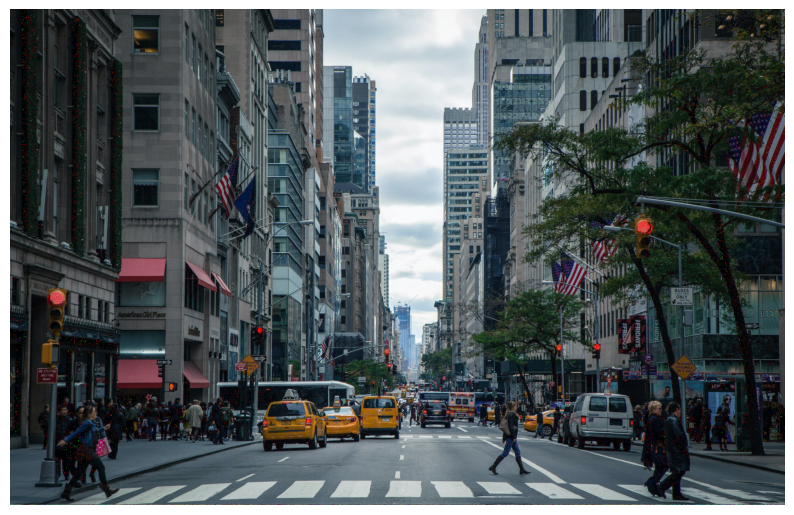

In [ ]:
padded_img2 = pad_image(original_img2)
compressed_img2 = encode_image(padded_img2, block_size, quant_matrix, loss_factor)
reconstructed_img2 = decode_image(compressed_img2, block_size, quant_matrix, padded_img2.shape, loss_factor)

display_images([reconstructed_img2])

compressed_size_img1 = get_image_size(compressed_img1)
compressed_size_img2 = get_image_size(compressed_img2)
original_size_img1 = get_image_size(original_img1)
original_size_img2 = get_image_size(original_img2)

In [ ]:
print("Image Compression Summary:")
print(f"Original size of Image 1: {original_size_img1:.2f} MB")
print(f"Compressed size of Image 1: {compressed_size_img1:.2f} MB")
print(f"Original size of Image 2: {original_size_img2:.2f} MB")
print(f"Compressed size of Image 2: {compressed_size_img2:.2f} MB")

Image Compression Summary:
Original size of Image 1: 57.11 MB
Compressed size of Image 1: 2.48 MB
Original size of Image 2: 47.35 MB
Compressed size of Image 2: 2.21 MB
